In [1]:
# importing the required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from tqdm import tqdm_notebook

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from tqdm import tqdm
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Read the updated data into model.
train_data = pd.read_csv('data/salesdf.csv')
product_data = pd.read_csv('data/productsdf.csv')
store_data = pd.read_csv('data/storesdf.csv')

In [3]:
train_data.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [4]:
# Convert the WEEK_END_DATE to datetime.
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])

In [5]:
# Look at first and last week in the dataset.
train_data.WEEK_END_DATE.min() , train_data.WEEK_END_DATE.max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

In [6]:
# Calculate number of weeks.
train_data.WEEK_END_DATE.nunique()

142

In [7]:
# Create array of unique week-ending dates.
week = train_data.WEEK_END_DATE.unique()

In [8]:
# Merge data into one dataset.
merged_data = train_data.merge(product_data,how='left', on='UPC')
merged_data = merged_data.merge(store_data, how='left', left_on='STORE_NUM', right_on='STORE_ID')

In [9]:
merged_data = merged_data.drop(columns=['STORE_ID'])

In [10]:
# Look at 1st row of data.
merged_data.loc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4                                     0
SUB_CATEGORY_1      

---
 *  `train_start`  Data split train set start week
 *  `train_end`  Data split train set end week
 *  `no_days_train`  Number of days we have in the particular validation set
 *  `validation_week`  Data split validation week
 *  `test_week`  Data split test week
 *  `train_shape` Datapoints available in the train split 
 *  `validation_shape` Datapoints available in the validation week
 *  `test_shape` Datapoints available in the test week
---

In [11]:
# Validation dataframe.
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
   
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [12]:
# Validation sets for training size = 3 months. Number of validation sets = 3.
validation_df(merged_data, week, no_of_months= 3, no_of_validation= 3)

,train_shape,validation_shape,test_shape,train_start,train_end,validate_week,test_week,no_days_train,set_no
0,19647,1640,1642,2011-06-15,2011-08-31,2011-09-14,2011-09-28,84 days,set1
1,19657,1632,1638,2011-06-08,2011-08-24,2011-09-07,2011-09-21,84 days,set2
2,19654,1629,1640,2011-06-01,2011-08-17,2011-08-31,2011-09-14,84 days,set3


In [13]:
# Validation sets for training size = 6 months. Number of validation sets = 4.
validation_df(merged_data, week, no_of_months= 6, no_of_validation= 4)

,train_shape,validation_shape,test_shape,train_start,train_end,validate_week,test_week,no_days_train,set_no
0,39294,1640,1642,2011-03-23,2011-08-31,2011-09-14,2011-09-28,168 days,set1
1,39308,1632,1638,2011-03-16,2011-08-24,2011-09-07,2011-09-21,168 days,set2
2,39308,1629,1640,2011-03-09,2011-08-17,2011-08-31,2011-09-14,168 days,set3
3,39308,1640,1632,2011-03-02,2011-08-10,2011-08-24,2011-09-07,168 days,set4


---
#### Calculate `EVALUATION METRIC - RMSLE` for each of the combination of traininig period size from 1 month to 12 months and number of validation sets from 1 to 5. Use RandomForestRegressor Model.
---

In [14]:
# Calculate  root mean squared log error.
def get_msle(true, predicted) :
    return np.sqrt(msle( true, predicted))

# Calculate RMSLE on train and validation sets.
def my_model(train_d, validate_d):
    
    train_x = train_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = validate_d['UNITS']
    
    model_RFR = RandomForestRegressor(max_depth=20,random_state=0)
    model_RFR.fit(train_x, train_y)
            
    predict_validate = model_RFR.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)
    
    return get_msle(valid_y, predict_validate)
    
def train_model(df,no_of_month):
    
    model_results = []
    for row in range(df.shape[0]):
        row = df.iloc[row]
        train_set = train_data[(train_data.WEEK_END_DATE >= row['train_start']) & (train_data.WEEK_END_DATE <= row['train_end'])]
        validate_set = train_data[train_data.WEEK_END_DATE == row['validate_week']]
        train_set['month'] = no_of_month
        validate_set['month'] = no_of_month
        model_results.append(my_model(train_set,validate_set))
        
    return np.mean(model_results), np.std(model_results)

---

Now, we define a function `get_matrix` that will take parameter `max_months` the number of months of training period and `max_cv` the number of validation sets.

It will return mean rmsle and standard deviation of the rmsle calculated over the different combinations of the months and validation sets.

---

In [15]:
# Define get matrix.
def get_matrix(max_months=1, max_cv=1):
    final_results_mean = []
    final_results_std = []
    
    for i in tqdm(range(1,max_months+1,1)):
        for j in range(1,max_cv+1,1):
            #print(i,j,'done')
            x = {}
            y = {}
            x['No_of_months'] = i
            x['validation_sets'] = j
            y['No_of_months'] = i
            y['validation_sets'] = j
            x['Results'] , y['Results'] = train_model(validation_df(merged_data, week, no_of_months=i, no_of_validation=j),i)
            final_results_mean.append(x)
            final_results_std.append(y)
            
    return pd.DataFrame.from_dict(final_results_mean).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0) , pd.DataFrame.from_dict(final_results_std).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0)

In [16]:
# Try with the months from range 1 to 12 and validation sets 1 to 5.
final_mean, final_std = get_matrix(max_months=12,max_cv=5)

100%|██████████| 12/12 [00:43<00:00,  3.63s/it]


---
#### Look at results from different combinations of training periods and validation sets.
---

In [17]:
# Returned dataframe has multiindex columns, so will drop one level.
final_mean.columns = final_mean.columns.droplevel()

(12.0, 0.0)

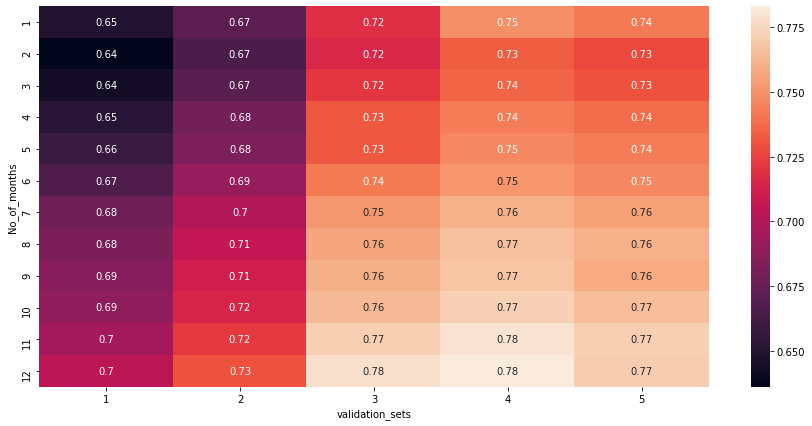

In [18]:
# Correlation plot of the variables in the train data.
plot = final_mean[final_mean.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---
- As size of the training period increases, the value of RMSLE increases. And for 2 months of train data we are getting the best score. It keeps increasing as we go further back. So, will repeat, keeping the max training period at 4 months and number of validation sets at 15.
---

In [19]:
final_mean2, final_std2 = get_matrix(max_months=4,max_cv=15)

100%|██████████| 4/4 [00:46<00:00, 11.60s/it]


(4.0, 0.0)

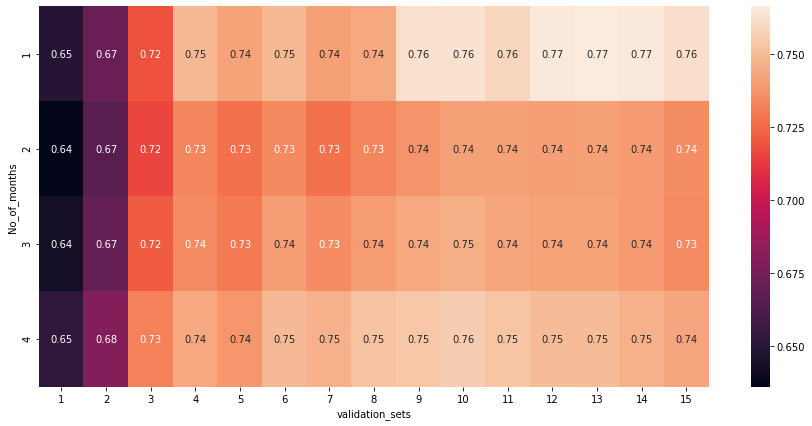

In [20]:
# Correlation plot of variables in train data.
final_mean2.columns = final_mean2.columns.droplevel()
plot = final_mean2[final_mean2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---
#### Now, Using the training period of 2 months, the RMSLE value gets stable after the 9 validation sets to value of 0.74.
---

### Standard Deviation

Now, Let's see the standard deviation of the results over the validation sets.

(4.0, 0.0)

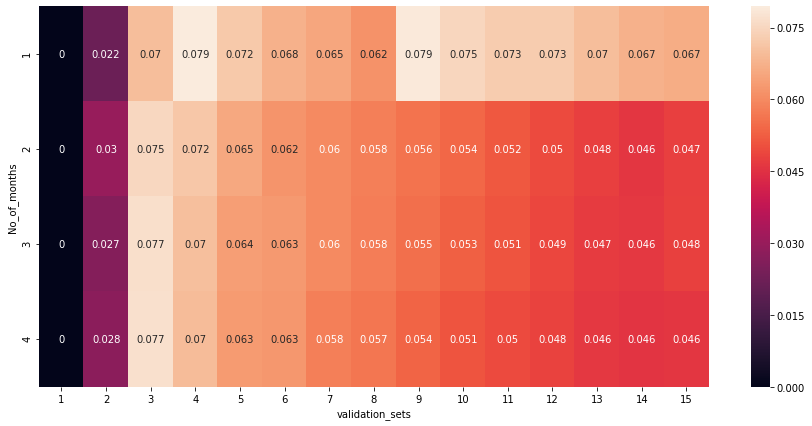

In [21]:
# Correlation plot of variables in the train data.
final_std2.columns = final_std2.columns.droplevel()
plot = final_std2[final_std2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---
#### The lowest standard deviation is with 14 validation sets, and we can also see that the standard deviation increases with 15th validation set in both 2 and 3 months period results.
---
#### So, we will validate the model with 2 months of training period and 14 validation sets.

---
---
---


---
---

### `OPTIMUM VALUE OF N_ESTIMATORS`


- First of all, we will calculate the performance of the model using the default features and we will try to tune the parameters to get the best results.

- So, first we will find out the optimal value of n_estimators for the Random Forest Model and we will see the performance of the model on n_estimators value 5, 15, 25..... 245.

---

In [22]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

# function to return the columns on which the model is trained
def get_colums(data):
    print('\n####### The model is trained on Following Columns: ###########\n')
    print(data.columns)
    print('===============================================================')


# function to train the model 
# it will calculate and return the RMSLE on train and validation set    
def my_model(train_d, validate_d, model):    
    train_x = train_d.drop(columns=['WEEK_END_DATE', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'UNITS'])
    valid_y = validate_d['UNITS']
    
    model.fit(train_x, train_y)
    
    predict_train = model.predict(train_x)
    predict_train = predict_train.clip(min=0)
            
    predict_validate = model.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)
    
    return get_msle(train_y, predict_train), get_msle(valid_y, predict_validate), train_x
    
    
    
# function will extract the train and validation set using validation set dataframe
# The defined model will train on each of the set and the average RMSLE on train and validate set will be returned
def train_model(df, data, model):
    
    model_results_train = []
    model_results_valid = []
    for row in tqdm_notebook(range(df.shape[0]),leave=False, desc='training_model'):
        
        row = df.iloc[row]
        train_set = data[(data.WEEK_END_DATE >= row['train_start']) & (data.WEEK_END_DATE <= row['train_end'])]
        validate_set = data[data.WEEK_END_DATE == row['validate_week']]        
        train, valid, data_train = my_model(train_set,validate_set, model)
        model_results_train.append(train)
        model_results_valid.append(valid)
        
    return np.mean(model_results_train) , np.mean(model_results_valid), data_train

In [23]:
estimator_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])


valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)

for estimator in tqdm_notebook(range(5,250,10),leave=True, desc= 'estimator'):    
    result = {}
    model_RFR = RandomForestRegressor(n_estimators= estimator, random_state=0)
    rmsle_train, rmsle_valid, data_train = train_model(valid_df, data, model_RFR)
    result['estimator'] = estimator
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    estimator_results.append(result)
    
get_colums(data_train)



####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')


In [24]:
x = pd.DataFrame.from_dict(estimator_results)

In [25]:
x

,estimator,rmsle_train,rmsle_valid
0,5,0.347728,0.527201
1,15,0.339513,0.517293
2,25,0.337711,0.514458
3,35,0.336986,0.512994
4,45,0.336643,0.512876
5,55,0.336404,0.512068
6,65,0.336214,0.511716
7,75,0.336078,0.511386
8,85,0.336003,0.511352
9,95,0.335934,0.511359


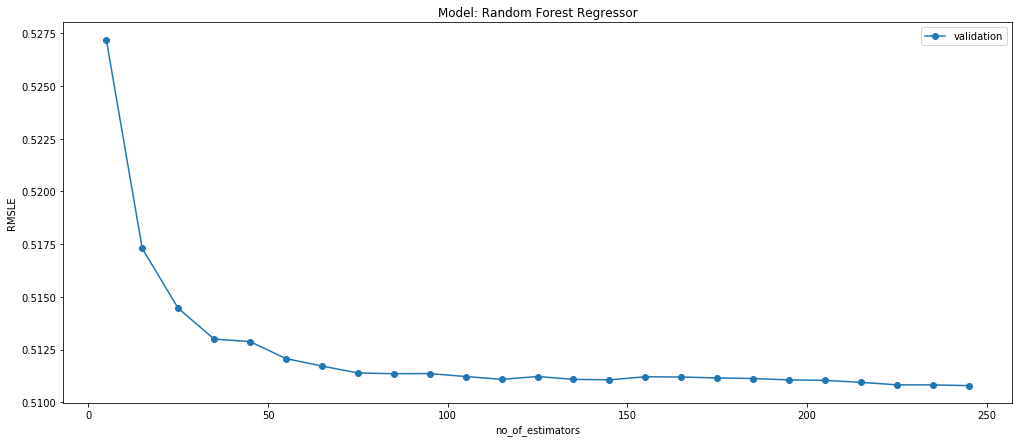

In [26]:
plt.figure(figsize=(17,7))
plt.plot(x['estimator'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('no_of_estimators')
plt.legend();

---
### `N_ESTIMATORS = 175`
---

The `RMSLE` is lowest on `n_estimators` value `175` is around 0.667 and seems to get stable after that. So, we will keep the value of the n_estimators = 175.



---

### `OPTIMUM VALUE OF MAX_DEPTH` 
---

Now, we will keep the value of `n_estimators` fixed as `175` and try different values of max_depth from 1, 2, ...29.

---

In [27]:
depth_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])


valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)
for depth in tqdm_notebook(range(1,30,1), leave=True, desc= 'max_depth'):    
    result = {}

    model_RFR = RandomForestRegressor(max_depth=depth,n_estimators=175)

    rmsle_train, rmsle_valid , data_train = train_model(valid_df, data, model_RFR)
    result['depth'] = depth
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    depth_results.append(result)
    
get_colums(data_train)



####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')


In [28]:
x = pd.DataFrame.from_dict(depth_results)

In [29]:
x

,depth,rmsle_train,rmsle_valid
0,1,0.934384,0.936865
1,2,0.825135,0.834442
2,3,0.739896,0.758267
3,4,0.673906,0.699131
4,5,0.631898,0.665750
5,6,0.585220,0.631552
6,7,0.543250,0.601585
7,8,0.508169,0.578164
8,9,0.476259,0.556525
9,10,0.448519,0.539950


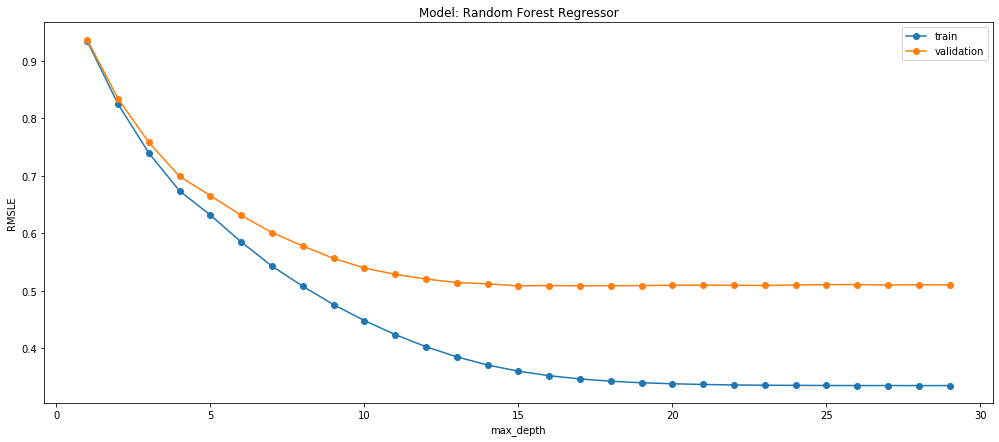

In [30]:

plt.figure(figsize=(17,7))
plt.plot(x['depth'], x['rmsle_train'], marker='o',label='train');
plt.plot(x['depth'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('max_depth')
plt.legend();

### `MAX_DEPTH = 10`

The RMSLE gets stable on both validation and train set after max_depth 10 and the RMSLE is still around 0.67

---
---

### `ADD TIME BASED FEATURES`

- Now, we will add some Time based features to the data like year of the transaction, month, day, day_of_year, week, quarter.

- And we will once again check the performace of the model for different max_depth 1 to 29 and will decide whether we have selected the right value of max_depth or not. 



---

In [31]:
# year
merged_data['year']  = merged_data['WEEK_END_DATE'].dt.year
# month
merged_data['month'] = merged_data['WEEK_END_DATE'].dt.month
# day
merged_data['day'] = merged_data['WEEK_END_DATE'].dt.day
# day_of year
merged_data['day_of_year'] = merged_data['WEEK_END_DATE'].dt.dayofyear
# week 
merged_data["week"] = merged_data['WEEK_END_DATE'].dt.week
# quarter
merged_data["quarter"] = merged_data['WEEK_END_DATE'].dt.quarter

In [32]:
depth_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)
for depth in tqdm_notebook(range(1,16,1), desc='max_depth', leave=True):    
    result = {}

    model_RFR = RandomForestRegressor(max_depth= depth, n_estimators= 175)

    rmsle_train, rmsle_valid, data_train = train_model(valid_df, data, model_RFR)
    result['depth'] = depth
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    depth_results.append(result)
    
get_colums(data_train)



####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'month', 'day',
       'day_of_year', 'week', 'quarter'],
      dtype='object')


In [33]:
x = pd.DataFrame.from_dict(depth_results)
x

,depth,rmsle_train,rmsle_valid
0,1,0.934069,0.936659
1,2,0.825272,0.833733
2,3,0.740329,0.759179
3,4,0.673938,0.700639
4,5,0.630980,0.668328
5,6,0.583678,0.634267
6,7,0.541977,0.606128
7,8,0.504992,0.584964
8,9,0.470720,0.567512
9,10,0.438534,0.553799


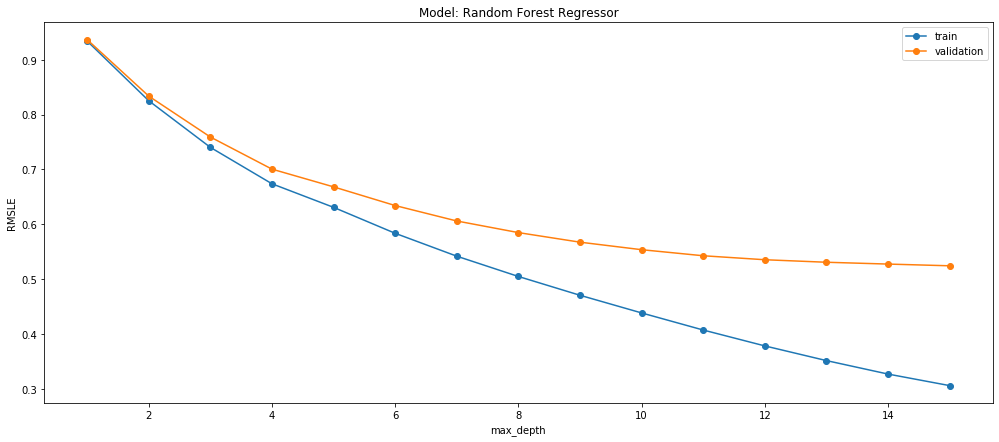

In [34]:
x = pd.DataFrame.from_dict(depth_results)
plt.figure(figsize=(17,7))
plt.plot(x['depth'], x['rmsle_train'], marker='o',label='train');
plt.plot(x['depth'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('max_depth')
plt.legend();

---
---

***So, we can still see that the value of RMSLE on both train and validation set is getting stable after the max_depth 10. Now, we will keep on adding the new features to the data and check if it is improving the results or not.*** 



- `max_depth` : 10
- `no_of_estimators` : 175


---
### `NEW FEATURES`
---

In [35]:
# read the columns 'STORE_NUM' and 'UPC' from the train data
original_train_data = pd.read_csv('data/sales.csv', usecols= ['STORE_NUM','UPC'])

In [36]:
# read the original product_data
original_product_data = pd.read_csv('data/product_data.csv')

In [37]:
original_product_data.head(5)

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML
4,1111038080,PL ANTSPTC SPG MNT MTHWS,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [38]:
# merge the train and product data
original_train_data = original_train_data.merge(original_product_data, how='left',on = 'UPC')

In [39]:
# Now, we will create another dataframe unique_store_data
# We will group the data by STORE_NUM and find unique values of the features 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'

unique_store_data = original_train_data.groupby(['STORE_NUM'])['MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'].nunique().reset_index()

In [40]:
# rename the columns of the dataframe 'unique_store_data'
unique_store_data.columns = ['STORE_NUM', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY']

In [41]:
# now , merge this new dataframe with the dataframe that has all the features.
data_with_unique_store = merged_data.merge(unique_store_data, how= 'left', on= 'STORE_NUM')

In [42]:
# let's have a look at the data 
data_with_unique_store.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,...,AVG_WEEKLY_BASKETS,year,month,day,day_of_year,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY
0,2009-01-14,367,1111009477,1.57,0,0,13,1,0,0,...,12707,2009,1,14,14,3,1,4,3,5
1,2009-01-14,367,1111009497,1.39,0,0,20,1,0,0,...,12707,2009,1,14,14,3,1,4,3,5
2,2009-01-14,367,1111085319,1.88,0,0,14,1,0,0,...,12707,2009,1,14,14,3,1,4,3,5
3,2009-01-14,367,1111085345,1.88,0,0,29,1,0,0,...,12707,2009,1,14,14,3,1,4,3,5
4,2009-01-14,367,1111085350,1.98,0,0,35,1,0,0,...,12707,2009,1,14,14,3,1,4,3,5


In [43]:
# train a model with the new features.
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)
new_data = data_with_unique_store.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

In [44]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.43505187496530645
RMSLE on validation set: 0.5509033315330136


In [45]:
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'month', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY'],
      dtype='object')

---

***Here, we can see that there is significant improvement in the model performance. On the validation set RMSLE is now `0.551`***

---

---
---

### Create Lag Features


Now, we will create the lag features, which will be the number of units ordered of the same product from the same store at exactly one year ago.

---

In [46]:
# Define a function that will return calculate the units sold number of a particular product from a particular store.
# We need to calculate this for a lag of 52 Weeks.

def get_lag_feature(data, no_of_week=1, return_Series= False):
    data_copy = data.copy()
    sample_1 = data_copy[['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    data_copy['NEW_DATE'] = data_copy.WEEK_END_DATE + timedelta(days = no_of_week*7)
    data_copy['PAST_DATE'] = data_copy.WEEK_END_DATE
    
    sample_2 = data_copy[['NEW_DATE','PAST_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    final = sample_1.merge(sample_2, how = 'left', left_on = ['WEEK_END_DATE', 'STORE_NUM', 'UPC'], right_on = ['NEW_DATE', 'STORE_NUM', 'UPC'])
    final = final.drop(columns=['NEW_DATE'])
    final.fillna(0,inplace = True)
    
    if return_Series:
        return final['UNITS_y']
    else: return final

In [47]:
# Let's verify the function is correct or not.
# In the following dataframe, We have UNITS_x as the units sold on the transaction data
# In the following dataframe, We have UNITS_y as the units sold on the PAST_DATE

get_lag_feature(merged_data, no_of_week = 8)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS_x,PAST_DATE,UNITS_y
0,2009-01-14,367,1111009477,13,0,0.0
1,2009-01-14,367,1111009497,20,0,0.0
2,2009-01-14,367,1111085319,14,0,0.0
3,2009-01-14,367,1111085345,29,0,0.0
4,2009-01-14,367,1111085350,35,0,0.0
...,...,...,...,...,...,...
232260,2011-09-28,29159,7192100336,32,2011-08-03 00:00:00,16.0
232261,2011-09-28,29159,7192100337,31,2011-08-03 00:00:00,10.0
232262,2011-09-28,29159,7192100339,23,2011-08-03 00:00:00,13.0
232263,2011-09-28,29159,7797502248,8,2011-08-03 00:00:00,7.0


In [48]:
# let's see the last third row of the dataframe
merged_data.loc[(merged_data.WEEK_END_DATE == '2011-09-28') & (merged_data.STORE_NUM == 29159) & (merged_data.UPC == 7192100339), 'UNITS']

232262    23
Name: UNITS, dtype: int64

In [49]:
merged_data.loc[(merged_data.WEEK_END_DATE == '2011-08-03') & (merged_data.STORE_NUM == 29159) & (merged_data.UPC == 7192100339), 'UNITS']

219172    13
Name: UNITS, dtype: int64

---

In [50]:
#  create a feature UNITS BEFORE 52_WEEK
data_with_unique_store['UNITS_BEFORE_52WEEK'] = get_lag_feature(data_with_unique_store, no_of_week= 52, return_Series= True)

In [51]:
# train the model with the new feature

model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

new_data = data_with_unique_store.drop(columns= ['STORE_NUM', 'UPC'])
valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

In [52]:
# mean RMSLE on train and validation set
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.4120165602602613
RMSLE on validation set: 0.57196646915787


In [53]:
# columns on the updated data.
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'month', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY', 'UNITS_BEFORE_52WEEK'],
      dtype='object')

---

***We can see a slight change in the RMSLE on the validaiton set. It is `0.571` now***

---

---

### `DIFFERENCE IN PRICE FROM LAST WEEK`

This will be our new feature. Whether the increase/decrease in price from the last week makes any difference to the model or not. 


---

In [54]:
# get the price difference
data_with_unique_store['price_difference'] = data_with_unique_store['BASE_PRICE'] - data_with_unique_store.groupby(['STORE_NUM', 'UPC'])['BASE_PRICE'].shift(1)

In [55]:
# let's verify we have calculated the right price difference or not
data_with_unique_store.loc[(data_with_unique_store.STORE_NUM == 367) & (data_with_unique_store.UPC == 1111009477),['STORE_NUM', 'UPC', 'BASE_PRICE', 'price_difference','UNITS']].head(10)

,STORE_NUM,UPC,BASE_PRICE,price_difference,UNITS
0,367,1111009477,1.57,NaN,13
1640,367,1111009477,1.57,0.00,24
3276,367,1111009477,1.36,-0.21,7
4912,367,1111009477,1.38,0.02,12
6552,367,1111009477,1.50,0.12,16
8179,367,1111009477,1.49,-0.01,21
9814,367,1111009477,1.49,0.00,11
11427,367,1111009477,1.49,0.00,10
13040,367,1111009477,1.39,-0.10,13
14677,367,1111009477,1.48,0.09,13


In [56]:
# fill the null values in the price difference with 0
data_with_unique_store.price_difference.fillna(0,inplace=True)

In [57]:
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

new_data = data_with_unique_store.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(new_data, week, no_of_months= 2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

In [58]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.4127944062262127
RMSLE on validation set: 0.5707247155315347


In [59]:
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'month', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY', 'UNITS_BEFORE_52WEEK', 'price_difference'],
      dtype='object')

---

The performance of the model has not changed. It is same as before.

---

### `AVERAGE BEFORE 2 MONTH`

- As we have one week gap between the training period and the validation set so for each store and product combination we will calculate the average units sold in 2 months before 1 week.
- In simple terms, the average number of units sold from 7 days to 63 days ago
- Let's see is this feature useful to us or not.

---

In [60]:
# make 2 columns one with 63 days difference from the week end date and another with 7 days difference
data_with_unique_store['2_MONTH_BEFORE'] = data_with_unique_store.WEEK_END_DATE - timedelta(days=63)
data_with_unique_store['1_WEEK_BEFORE'] = data_with_unique_store.WEEK_END_DATE - timedelta(days=7)

In [61]:
data_with_unique_store[['WEEK_END_DATE', '2_MONTH_BEFORE', '1_WEEK_BEFORE']].tail()

,WEEK_END_DATE,2_MONTH_BEFORE,1_WEEK_BEFORE
232260,2011-09-28,2011-07-27,2011-09-21
232261,2011-09-28,2011-07-27,2011-09-21
232262,2011-09-28,2011-07-27,2011-09-21
232263,2011-09-28,2011-07-27,2011-09-21
232264,2011-09-28,2011-07-27,2011-09-21


In [62]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
# calculate the average units in the period
def get_average_units(x):
    data_2month = data_with_unique_store[(data_with_unique_store.WEEK_END_DATE <= x['1_WEEK_BEFORE']) & (data_with_unique_store['WEEK_END_DATE'] >= x['2_MONTH_BEFORE']) & (data_with_unique_store['STORE_NUM'] == x['STORE_NUM']) & (data_with_unique_store['UPC'] == x['UPC']) ]
    return data_2month.UNITS.mean() 

In [63]:
data_with_unique_store['AVERAGE_UNITS_IN_2_MONTH'] = data_with_unique_store.progress_apply(get_average_units,axis=1)

In [64]:
# fill the null values with 0
data_with_unique_store.AVERAGE_UNITS_IN_2_MONTH.fillna(0,inplace=True)

In [65]:
# drop the date columns that we have created, as they are of no use now.
new_data = data_with_unique_store.drop(columns=['2_MONTH_BEFORE','1_WEEK_BEFORE', 'STORE_NUM', 'UPC'])

In [66]:
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df,new_data, model_RFR)

In [67]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.34488532036740366
RMSLE on validation set: 0.46293259720958246


In [68]:
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'month', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY', 'UNITS_BEFORE_52WEEK', 'price_difference',
       'AVERAGE_UNITS_IN_2_MONTH'],
      dtype='object')

---

- The last feature that we added has made significant improvement in the RMSLE score on the validation data.
- The RMSLE is now `0.4677`

In [70]:
data = data_with_unique_store

In [71]:
# check for the null values
data.isna().sum().sum()

0

In [72]:
data.loc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4                                     0
SUB_CATEGORY_1      

In [73]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [74]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [75]:
week = data.WEEK_END_DATE.unique()

In [76]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [77]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,train_start_1,train_end_1,train_start_2,validate_week,test_week,no_days_train_1,no_days_train_2,set_no
0,2011-07-13,2011-08-31,2011-07-27,2011-09-14,2011-09-28,56 days,56 days,set1
1,2011-07-06,2011-08-24,2011-07-20,2011-09-07,2011-09-21,56 days,56 days,set2
2,2011-06-29,2011-08-17,2011-07-13,2011-08-31,2011-09-14,56 days,56 days,set3
3,2011-06-22,2011-08-10,2011-07-06,2011-08-24,2011-09-07,56 days,56 days,set4
4,2011-06-15,2011-08-03,2011-06-29,2011-08-17,2011-08-31,56 days,56 days,set5
5,2011-06-08,2011-07-27,2011-06-22,2011-08-10,2011-08-24,56 days,56 days,set6
6,2011-06-01,2011-07-20,2011-06-15,2011-08-03,2011-08-17,56 days,56 days,set7
7,2011-05-25,2011-07-13,2011-06-08,2011-07-27,2011-08-10,56 days,56 days,set8
8,2011-05-18,2011-07-06,2011-06-01,2011-07-20,2011-08-03,56 days,56 days,set9
9,2011-05-11,2011-06-29,2011-05-25,2011-07-13,2011-07-27,56 days,56 days,set10


In [78]:
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [79]:
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [80]:
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

In [81]:
def get_results_on_evaluation_set(eval_set, model):
    results = []
    set_n = 1
    for eval_data in tqdm(eval_set):
        
        x = {}
        train_data_1, validate, train_data_2, test = eval_data
        
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']
        
        train_data_2_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_2_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        model_valid = model.fit(train_data_1_x, train_data_1_y)
        
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
                
        model_test  = model.fit(train_data_2_x, train_data_2_y)
        
        predict_train_2 = model_test.predict(train_data_2_x).clip(min=0)
        predict_test    = model_test.predict(test_x).clip(min=0)
        
        rmsle_train_1 = get_msle(train_data_1_y, predict_train_1)
        rmsle_valid   = get_msle(validate_y, predict_valid)
        
        rmsle_train_2 = get_msle(train_data_2_y, predict_train_2)
        rmsle_test    = get_msle(test_y, predict_test)
        
        x['set_no'] = set_n
        set_n +=1
        x['rmsle_train_1'] = rmsle_train_1
        x['rmsle_valid'] = rmsle_valid
        x['rmsle_train_2'] = rmsle_train_2
        x['rmsle_test'] = rmsle_test
        results.append(x)
        
    return pd.DataFrame.from_dict(results)  

In [82]:
# Get the best 10 feature importance plot
def get_feature_importance(eval_set, model):
    train_data_1, validate, train_data_2, test = eval_set
    
    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']
        
    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    model.fit(train_data_x, train_data_y)
    (pd.Series(model.feature_importances_, index=train_data_x.columns).nlargest(10).plot(kind='barh')) 


---

## `RandomForest`

---

In [83]:
model_rf = RandomForestRegressor(max_depth=10, n_estimators=175, random_state=0)

results_RFR = get_results_on_evaluation_set(evaluation_sets, model_rf)

100%|██████████| 14/14 [06:50<00:00, 29.29s/it]


In [84]:
results_RFR[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.353240,0.416301
1,0.355415,0.493602
2,0.363767,0.401761
3,0.350412,0.463373
4,0.344208,0.558591
5,0.349586,0.479080
6,0.339725,0.465425
7,0.334268,0.534997
8,0.328488,0.432694
9,0.332360,0.470960


In [85]:
results_RFR[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.345734
rmsle_test       0.461229
dtype: float64

---

### `XGBOOST`
---

In [87]:
import xgboost as xgb
from catboost import CatBoostRegressor
from tqdm import tqdm
from datetime import timedelta

In [88]:
model_XGB = xgb.XGBRegressor(n_estimators = 720,
                             subsample = 1,
                             max_depth = 4,
                             min_child_weight = 2,
                             gamma = 0,
                             learning_rate = 0.01,
                             n_jobs = 4,
                             random_state = 0,
                             objective ='reg:squarederror')

In [89]:
results_XGB = get_results_on_evaluation_set(evaluation_sets, model_XGB)

100%|██████████| 14/14 [04:41<00:00, 20.12s/it]


In [90]:
results_XGB[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.409367,0.433260
1,0.413264,0.475992
2,0.414448,0.406275
3,0.406377,0.473980
4,0.403941,0.549743
5,0.401243,0.482788
6,0.391651,0.477092
7,0.388893,0.543432
8,0.383705,0.540936
9,0.384872,0.457406


In [91]:
results_XGB[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.400409
rmsle_test       0.472702
dtype: float64

---

## `CATBOOST`

---

In [92]:
# read the data for the catboost model
catboost_data = pd.read_csv('data/catboost_data.csv')

In [93]:
# convert WEEK_END_DATE to datetime format
catboost_data.WEEK_END_DATE = pd.to_datetime(catboost_data.WEEK_END_DATE)

In [94]:
validation_df(catboost_data, week, no_of_months=2, no_of_validation=14)

,train_start_1,train_end_1,train_start_2,validate_week,test_week,no_days_train_1,no_days_train_2,set_no
0,2011-07-13,2011-08-31,2011-07-27,2011-09-14,2011-09-28,56 days,56 days,set1
1,2011-07-06,2011-08-24,2011-07-20,2011-09-07,2011-09-21,56 days,56 days,set2
2,2011-06-29,2011-08-17,2011-07-13,2011-08-31,2011-09-14,56 days,56 days,set3
3,2011-06-22,2011-08-10,2011-07-06,2011-08-24,2011-09-07,56 days,56 days,set4
4,2011-06-15,2011-08-03,2011-06-29,2011-08-17,2011-08-31,56 days,56 days,set5
5,2011-06-08,2011-07-27,2011-06-22,2011-08-10,2011-08-24,56 days,56 days,set6
6,2011-06-01,2011-07-20,2011-06-15,2011-08-03,2011-08-17,56 days,56 days,set7
7,2011-05-25,2011-07-13,2011-06-08,2011-07-27,2011-08-10,56 days,56 days,set8
8,2011-05-18,2011-07-06,2011-06-01,2011-07-20,2011-08-03,56 days,56 days,set9
9,2011-05-11,2011-06-29,2011-05-25,2011-07-13,2011-07-27,56 days,56 days,set10


In [95]:
catboost_evaluation_set = get_evaluation_sets(catboost_data,
                                              validation_df(catboost_data,
                                                            week,
                                                            no_of_months=2,
                                                            no_of_validation=14))

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [96]:
categorical_feature_indices = [1, 16, 17, 18, 19, 20, 21, 22, 23]

In [97]:
model_CBR = CatBoostRegressor(n_estimators=1800,
                              l2_leaf_reg=3,
                              max_depth=8,
                              learning_rate= 0.075,
                              objective='RMSE',
                              verbose=False,
                              eval_metric='MSLE',
                              cat_features=categorical_feature_indices)

In [98]:
results_CBR = get_results_on_evaluation_set(catboost_evaluation_set, model_CBR)

100%|██████████| 14/14 [50:53<00:00, 218.13s/it] 


In [99]:
results_CBR[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.297189,0.421793
1,0.300668,0.503896
2,0.297359,0.406415
3,0.292633,0.469835
4,0.294790,0.539858
5,0.294282,0.500790
6,0.289677,0.479806
7,0.285159,0.547076
8,0.284053,0.486597
9,0.288318,0.519067


In [100]:
results_CBR[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.292115
rmsle_test       0.466371
dtype: float64

---

### `FEATURE IMPORTANCE`

---

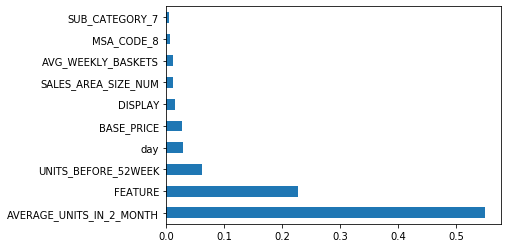

In [101]:
get_feature_importance(evaluation_sets[0], model_rf)

In [ ]:
get_feature_importance(evaluation_sets[0], model_XGB)

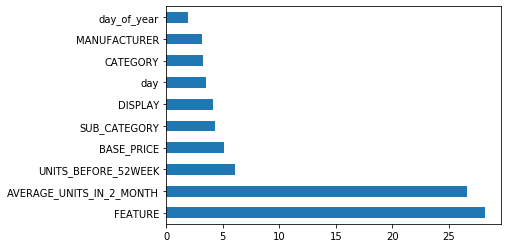

In [103]:
get_feature_importance(catboost_evaluation_set[0], model_CBR)

---

## `Ensemble Model`


---



def get_score(model_result1, model_result2, weight=0.35):
    
    true1, prediction1 = model_result1
    true2, prediction2 = model_result2
    prediction = prediction1*weight + prediction2*(1 - weight)
    return get_msle(true1, prediction)

def get_ensemble_score(results_model1, results_model2, set_n) :
    
    train_1_model1, valid_model1 = results_model1
    
    train_1_model2, valid_model2 = results_model2
      
   
    x = {}
    x['set_n'] = set_n
    x['train_rmsle'] = get_score(train_1_model1, train_1_model2)
    x['test_rmsle']   = get_score(valid_model1, valid_model2)
        
    return x

def get_ensemble_results_on_evaluation_set(eval_set, eval_set_2, model1, model2):
    results = []
    set_n = 1
    for eval_data, eval_data_2 in tqdm(zip(eval_set,eval_set_2)):
        
        train_data_1, validate, train_data_2, test = eval_data
        
        
        train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        model = model1.fit(train_data_x, train_data_y)
        
        predict_train = model.predict(train_data_x).clip(min=0)
        predict_test   = model.predict(test_x).clip(min=0)
        
        results_model1 = ((train_data_y, predict_train),
                          (test_y, predict_test))
         
        
        ############################################################################
        
        train_data_1, validate, train_data_2, test = eval_data_2
        
        
        train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        model = model2.fit(train_data_x, train_data_y)
        
        predict_train = model.predict(train_data_x).clip(min=0)
        predict_test  = model.predict(test_x).clip(min=0)
        
        results_model2 = ((train_data_y, predict_train),
                          (test_y, predict_test))
        
        results.append(get_ensemble_score(results_model1, results_model2,set_n))
        set_n += 1
        
        
    return results

In [108]:
# final_ensemble_results = get_ensemble_results_on_evaluation_set(evaluation_sets, 
#                                                                catboost_evaluation_set, 
#                                                                model_XGB,
#                                                                model_CBR)

In [109]:
# pd.DataFrame.from_dict(final_ensemble_results).mean()